In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, svm, metrics
from sklearn.datasets import fetch_openml, load_digits
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import seaborn as sn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import scikitplot as skplt
from PIL import Image
from sklearn.decomposition import PCA

## Getting Creditcard Data (P2)

In [2]:
def ReadData():
    #importing data set(s)
    filename = 'default of credit card clients.xls'
    nanDict = {} #this does nothing with this data set
    #read file
    df = pd.read_excel(filename,header=1,skiprows=0,index_col=0,na_values=nanDict) 
    #rename last column
    df.rename(index=str, columns={"default payment next month": "defaultPaymentNextMonth"}, inplace=True)
    #Replace nonsensical values in PAY_i columns with 0
    for i in [0,2,3,4,5,6]:
        col = 'PAY_{}'.format(i)
        df[col].replace(to_replace=-2, value = 0, inplace=True)
    #shuffle dataset by row
    df.sample(frac=1)
    
    # Define features and targets 
    X = df.loc[:, df.columns != 'defaultPaymentNextMonth'].values
    y = df.loc[:, df.columns == 'defaultPaymentNextMonth'].values
    
    # Categorical variables to one-hots, setting nonsensical values to 0
    onehotencoder1 = OneHotEncoder(categories='auto')
    onehotencoder2 = OneHotEncoder(categories='auto',drop='first')

    # sets number of elements in onehot vectors automatically from data.
    Xt= ColumnTransformer(
        [("one", onehotencoder1, [1]),("two", onehotencoder2, [2,3]),],
        remainder="passthrough"
    ).fit_transform(X)

    # Train-test split
    trainingShare = 0.5
    seed  = 1
    XTrain, XTest, yTrain, yTest=train_test_split(Xt, y, train_size=trainingShare, \
                                                 random_state=seed, stratify = y)
    
    #scale data, except one-hotted
    sc = StandardScaler()
    XTrain_fitting = XTrain[:,11:]
    XTest_fitting = XTest[:,11:]
    #removes mean, scales by std
    XTrain_scaler = sc.fit_transform(XTrain_fitting)
    XTest_scaler = sc.transform(XTest_fitting)
    #puts together the complete model matrix again
    XTrain_scaled=np.c_[XTrain[:,:11],XTrain_scaler]
    XTest_scaled = np.c_[XTest[:,:11],XTest_scaler]


    
    
    return XTrain_scaled,XTest_scaled,yTrain,yTest

### Helper Functions for Plotting the Gains Curve on Top of Plott

In [13]:
def plot_lift(h,method):
    backg=np.array(Image.open("Gains_logreg.jpg"))

    fig, ax2 = plt.subplots(1,1)
    ax2.plot(h[1].get_xdata(), h[1].get_ydata(),'r--',dashes=(3,3), lw=3, label='fitted curve')
    ax2.legend(loc='right')
    ax2.imshow(backg,aspect='auto',extent=[0,1,0,1.065])

    ax2.set_title(method)
    ax2.set_xlabel('Number of total data',fontweight='bold')
    ax2.set_ylabel('Cumulative number of target data',fontweight='bold')

    ax2.set_xticks((0,0.33,0.66,1))
    ax2.set_xticklabels((0,5000,10000,15000))
    ax2.set_yticks((0,0.15,0.307,0.46,0.614,0.77,0.92,1.065))
    ax2.set_yticklabels((0,500,1000,1500,2000,2500,3000,3500));  
    plt.show()

In [4]:
def calc_area_ratio(pred,real):
    fig,ax = plt.subplots(1,1)
    y_te = two(pred)
    skplt.metrics.plot_cumulative_gain(real.ravel(), y_te,ax=ax)
    ax.grid(b=None)
    hh,ll=ax.get_legend_handles_labels()
    plt.close()
    defaults = sum(real == 1)
    total = len(real)
    defaultRate = defaults/total

    bestie=bestCurve(defaults,total,defaultRate)
    dia = np.linspace(0,1,15000)
    classi=hh[1].get_ydata()
    diff_c = np.sum(classi)-np.sum(dia)
    diff_b = np.sum(bestie[1])-np.sum(dia)+1 #adding a 1 on the end of bestie for dimensions?
    area_ratio = diff_c/diff_b
    return area_ratio,hh

In [5]:
def two(y): #helper function for lift curve plotting
    y_two = np.zeros(len(y))
    for i in range(len(y)):
        y_two[i] = 1-y[i]
    return np.c_[y_two,y]

In [6]:
def bestCurve(defaults, total, defaultRate): #create best curve
    x = np.linspace(0, 1, total)
    
    y1 = np.linspace(0, 1, defaults)
    y2 = np.ones(total-defaults)
    y3 = np.concatenate([y1,y2])
    return x, y3

## SVM on Credit Card Data

In [7]:
#Dividing dataset in train and test data
XTrain_CD,XTest_CD,yTrain_CD,yTest_CD = ReadData()

In [8]:
#making a model for classification
classifier = svm.SVC(C = 1, kernel = 'rbf', gamma = 'scale', verbose = True, decision_function_shape= 'ovo', probability = True)
classifier.fit(XTrain_CD, np.squeeze(yTrain_CD))
#function to give probabilities as output for calculating AUC and gains curve
predicted_CD = classifier.predict_proba(XTest_CD)
predicted_ = classifier.predict(XTest_CD)
#normal output for accuracy/error score
pred_train = classifier.predict_proba(XTrain_CD)
pred_train_ = classifier.predict(XTrain_CD)
print(np.shape(predicted_CD))
print(1-metrics.accuracy_score(yTest_CD, predicted_))
print(1-metrics.accuracy_score(yTrain_CD, pred_train_))
print(metrics.confusion_matrix(yTest_CD, predicted_))
print(metrics.confusion_matrix(yTrain_CD, pred_train_))

[LibSVM](15000, 2)
0.18033333333333335
0.17226666666666668
[[11145   537]
 [ 2168  1150]]
[[11201   481]
 [ 2103  1215]]


Test
0.45184080938699384
Train
0.5746157246304585
Confusion Matrix
[[11145  2168]
 [  537  1150]]


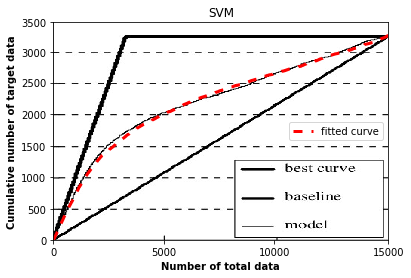

In [14]:
# calculation for area ratio and plotting of gains curve of SVM onto the plot of logreg
yyy = classifier.predict(XTest_CD)
print('Test')
print(calc_area_ratio(predicted_CD[:,1],yTest_CD)[0])
print('Train')
print(calc_area_ratio(pred_train[:,1], yTrain_CD)[0])
print('Confusion Matrix')
print(metrics.confusion_matrix(yyy,yTest_CD))

plot_lift(calc_area_ratio(predicted_CD[:,1],yTest_CD)[1],'SVM')

In [15]:
#Testing out PCA
n_comp =18
pca = PCA(n_components=n_comp)
X2D = pca.fit_transform(XTrain_CD)
X2Dt = pca.transform(XTest_CD)

In [16]:
classifier_pca = svm.SVC(C = 1, kernel = 'rbf', gamma = 'scale', verbose = True, decision_function_shape= 'ovo')
classifier_pca.fit(X2D, np.squeeze(yTrain_CD))
predicted_CD = classifier_pca.predict(X2Dt)
print(1-metrics.accuracy_score(yTest_CD, predicted_CD))
metrics.confusion_matrix(yTest_CD, predicted_CD)

[LibSVM]0.18046666666666666


array([[11137,   545],
       [ 2162,  1156]])

## MNIST

In [17]:
#Getting MNIST dataset. fetch_openml gets 28x28pixel dataset, and load_digits gets 8x8pixel dataset from scikit learn
mnist = fetch_openml('mnist_784')
#mnist = load_digits()
X = mnist.data
y = mnist.target

In [18]:
#Dividing data into training and test data sets
trainingShare = 0.8
seed  = 1234
XTrain, XTest, yTrain, yTest=train_test_split(X, y, train_size=trainingShare, \
                                              random_state=seed, stratify = y)

In [19]:
#Performing PCA on MNIST for faster runs of the model
n_comp =30
pca = PCA(n_components=n_comp)
X2D = pca.fit_transform(XTrain)
X2Dt = pca.transform(XTest)

In [20]:
#making SVM model for classification, trial and error based on the gridsearch for the small data set lead to using C = 3
svc = svm.SVC(C = 3, gamma = 'scale', kernel = 'rbf')
svc.fit(X2D, yTrain)
predicted = svc.predict(X2Dt)

#GridsearchCV performed on the small dataset (8x8pixel) other than standard settings for hyperparameters this yielded C = 2
#ameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':[1e-3, 1e-2, 1e-1, 1, 2, 3, 4, 4, 5, 10, 100], 'degree':np.linspace(1,10,10)}
#classifier = GridSearchCV(svc, parameters, cv = 5)  
#classifier = svc(C=2, kernel = 'rbf')

In [21]:
print(metrics.accuracy_score(yTest, predicted))
metrics.confusion_matrix(yTest, predicted)

0.9821428571428571


array([[1365,    0,    1,    1,    1,    0,    7,    1,    2,    2],
       [   0, 1564,    6,    0,    0,    0,    3,    1,    1,    0],
       [   2,    2, 1373,    4,    1,    2,    0,    6,    4,    4],
       [   0,    2,    7, 1387,    1,   10,    0,    7,    8,    6],
       [   1,    2,    0,    0, 1347,    0,    4,    0,    1,   10],
       [   2,    0,    0,    4,    3, 1238,    4,    0,    6,    6],
       [   3,    1,    2,    0,    6,    3, 1358,    0,    2,    0],
       [   1,    4,    4,    3,    4,    0,    0, 1431,    4,    8],
       [   0,    5,    6,    7,    0,    3,    6,    0, 1335,    3],
       [   5,    1,    1,    6,   13,    3,    1,    6,    4, 1352]])

In [22]:
#Plotter for nice seaborn confusion matrix
def plot_confusion(y_real,y_pred,labs):
    if not labs:
        labs = np.unique(y_real)
    y_pred=y_pred.reshape(y_real.shape)
    confused = confusion_matrix(y_real,y_pred,sample_weight = None)
    df_cm = pd.DataFrame(confused,columns=labs, index=labs)

    df_cm.index.name = 'Actual'
    df_cm.columns.name ='Predicted'
    plt.figure(figsize=(3,3))
    sn.set(font_scale=1.4)
    ax = sn.heatmap(df_cm, cmap="inferno",annot=True, fmt='g',annot_kws={"size":16})
    first,second=ax.get_ylim()
    ax.set_ylim(first+0.5,0)
    plt.show()
    sn.set(style="white") #fixes ugly backgrounds

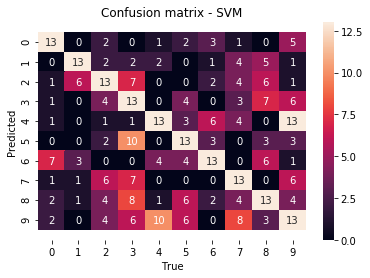

In [23]:
import pandas as pd
import seaborn as sn
a = metrics.confusion_matrix(predicted, yTest)
df = pd.DataFrame(a)

#scaling the diagonal to make a beautiful seaborn plot
np.fill_diagonal(df.values,0)
ultros=np.max(np.max(df))
np.fill_diagonal(df.values,ultros)

ax = sn.heatmap(df,annot=True)
bottom,top = ax.get_ylim()
ax.set_ylim(bottom+0.5,top-0.5)
ax.set_xlabel('True')
ax.set_ylabel('Predicted')
plt.title("Confusion matrix - SVM")
plt.show()

#display(df)

## SVM on Franke Funktion

In [24]:
"""
This is an "uglified" version of the FrankeFunction, to minimize use of costly functions like divisions and powers.
It takes as input parameters a meshgrid of coordinates in the x and y direction.
"""
def FrankeFunction(x,y): #still got one division in here
    term1 = 0.75*np.exp(-(0.25*(9*x-2)*(9*x-2)) - 0.25*((9*y-2)*(9*y-2)))
    term2 = 0.75*np.exp(-((9*x+1)*(9*x+1))/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)*(9*x-7)*0.25 - 0.25*((9*y-3)*(9*y-3)))
    term4 = -0.2*np.exp(-(9*x-4)*(9*x-4) - (9*y-7)*(9*y-7))
    return term1 + term2 + term3 + term4

In [25]:
"""
This function creates the Model Matrix, usually dubbed X, for regression analysis.
It takes as input parameters a meshgrid of coordinates in the x and y direction, 
and the polynomial degree P that you wish to fit.

The order of columns is different from the one scikit learn creates, so take care to use the same model-creator when
comparing scikit and this code.

The ordering this function creates is: x^0y^0, x^1y^0, x^2y^0, x^0y^1, x^1y^1, x^0y^2 for a 2nd order polynomial.
"""
def Model(x,y,P): 
#     m = len(x)*len(y) # number of equations
    m=len(x)
    t = sum(range(P+2)) # number of terms in polynomial
    X = np.zeros((m,t)) # Model matrix
#     a = np.matrix.flatten(x)
#     b = np.matrix.flatten(y)
    a=x
    b=x
    c = 0 #counter
    for i in range(P+1):
        for j in range(P+1-i):
            X[:,c] = a**j*b**i
            c +=1
    return X

In [26]:
#creating 2 datasets instead of doing train test split for ease of plotting.
N = 150 #number of points along x and y axes
np.random.seed(1111)
# sort this for meshgrid
x = np.sort(np.random.uniform(0,1,N))
y = np.sort(np.random.uniform(0,1,N))
x, y = np.meshgrid(x,y,sparse=False)

#create datapoints/results
z = FrankeFunction(x, y)

# Create noise
noise_weight = 0.1
Noise = noise_weight*np.random.randn(N,N)

#add noise
z_noise = z+Noise

#flatten for use in functions
z_n = np.matrix.flatten(z_noise)
X_matr = np.c_[np.matrix.flatten(x),np.matrix.flatten(y),z_n]
np.random.shuffle(X_matr)
Xshuf,yshuf = X_matr[:,:2],X_matr[:,2]

N2=20
# sort this for meshgrid
x2 = np.sort(np.random.uniform(0,1,N2))
y2 = np.sort(np.random.uniform(0,1,N2))
x2, y2 = np.meshgrid(x2,y2,sparse=False)

#create datapoints/results
z2 = FrankeFunction(x2, y2)

# Create noise
noise_weight2 = 0.1
Noise2 = noise_weight2*np.random.randn(N2,N2)

#add noise
z_noise2 = z2+Noise2

#flatten for use in functions
z_n2 = np.matrix.flatten(z_noise2)
X_matr2 = np.c_[np.matrix.flatten(x2),np.matrix.flatten(y2),z_n2]
np.random.shuffle(X_matr2)
Xshuf2,yshuf2 = X_matr2[:,:2],X_matr2[:,2]

#dividing in train and test data sets
xtr,ytr,xte,yte = Xshuf[:,:2],yshuf[:],Xshuf2[:,:2],yshuf2[:]


In [27]:
#Making SVM model for regression. Trial and error/ handtuning of parameters lead to the following hyper parameters.
svr = svm.SVR(C=1.5, gamma = 'scale',kernel='rbf', verbose=True, epsilon = 0.01)
fitR = svr.fit(xtr,ytr)
pred = svr.predict(xte)
pred_tr = svr.predict(xtr)
print('train')
print(metrics.r2_score(ytr, pred_tr))
print('test')
print(metrics.r2_score(yte, pred))

[LibSVM]train
0.8864318483591476
test
0.9168276703096502


In [28]:
print('test')
print(metrics.mean_squared_error(yte, pred))
print('train')
print(metrics.mean_squared_error(ytr, pred_tr))
print(1 / (150. * z_noise2.var())) #the value of "scale" in this problem, used for gamma in the SVM regression problem

test
0.009357793275239286
train
0.010128020613580733
0.059253520742205835


In [29]:
#attempt of running gridsearch. Was too optimistic with all these variable options for my tiny computer. 
#svr = svm.SVR(verbose=True)
#parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':[1e-3, 1e-2, 1e-1, 1, 2, 3, 4, 4, 5, 10, 100],'gamma':(0.0001, 0.001, 0.01, 0.05925,0.1,1, 1.5 ), 'degree':np.linspace(1,10,10), 'epsilon':np.linspace(0.001,1.5,10)}
#classifier_gs = GridSearchCV(svr, parameters, cv = 5)
#classifier_gs.fit(xtr,ytr)
